In [6]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import ttest_ind
import seaborn as sns

sns.set()

PROCESSED_DATA_PATH = './data/processed'
PLOTS_PATH = './plots'
CPI_PATH = './data/raw/CPIAUCNS.csv'

Load ```chars_extended.csv``` file containing the movie metadata collected from the wikidata

In [7]:
df_chars_extended = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'chars_extended.csv'))
def strip_year(date):
    if date is np.NaN:
        return np.NaN
    if len(date)==4:
        return datetime.strptime(date, '%Y').year
    if len(date)==7:
        return datetime.strptime(date, '%Y-%m').year
    if len(date)==10:
        return datetime.strptime(date, '%Y-%m-%d').year
    else:
        return np.NaN
df_chars_extended['movie_release'] = df_chars_extended['movie_release'].apply(strip_year)
df_chars_extended.head()

,movie_freebase_id,movie_id,movie_name,movie_genre,movie_origin,movie_release,box_office_value,director_id,director_name,director_gender,...,cast_3_country,cast_3_birth,cast_3_age_at_release,cast_id_4,cast_4_name,cast_4_gender,cast_4_country,cast_4_birth,cast_4_age_at_release,movie_imdb_id
0,/m/02rjv0t,Q1000394,This Modern Age,drama film,United States of America,1931.0,NaN,Q1985392,Nick Grinde,male,...,France,1878-06-02,53.0,Q2831060,Albert Conti,male,United States of America,1887-01-29,44.0,tt0022478
1,/m/0gjdn2_,Q1000174,Tinko,NaN,NaN,1957.0,NaN,Q1379822,Herbert Ballmann,male,...,Germany,1898-02-21,59.0,Q1442953,Hans Hardt-Hardtloff,male,Germany,1906-08-08,51.0,tt0131068
2,/m/0g5xtz,Q1000825,Jan Dara,LGBT-related film,Thailand,2001.0,NaN,Q360509,Nonzee Nimibutr,male,...,Thailand,1940-01-24,61.0,Q16305292,NaN,male,NaN,1975-03-26,26.0,tt0282628
3,/m/0czdkjd,Q1001102,The Rat Savior,horror film,Socialist Federal Republic of Yugoslavia,1976.0,NaN,Q3199956,Krsto Papić,male,...,Croatia,1932-01-04,44.0,Q12628320,Branko Špoljar,male,NaN,1914-01-05,62.0,tt0074701
4,/m/0f1r9p,Q1000826,Guns of the Magnificent Seven,Western film,United States of America,1969.0,NaN,Q450601,Paul Wendkos,male,...,United States of America,1914-07-24,55.0,Q465643,George Rigaud,male,Argentina,1905-08-11,64.0,tt0064395


Extract the gender information of the lead actors, director and producer

In [8]:
df_genders = df_chars_extended[['movie_id', 'movie_release', 'movie_genre', 'director_gender', 'producer_gender', 'cast_0_gender', 'cast_1_gender','cast_2_gender','cast_3_gender','cast_4_gender']]
df_genders = df_genders[df_genders['movie_release'].notna()]
df_genders['movie_release'] = df_genders['movie_release'].astype(int)
df_genders = df_genders.sort_values('movie_release')
df_genders.head()

,movie_id,movie_release,movie_genre,director_gender,producer_gender,cast_0_gender,cast_1_gender,cast_2_gender,cast_3_gender,cast_4_gender
46998,Q572269,1662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73440,Q875764,1815,fairy tale,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30038,Q3924909,1878,nature documentary,male,male,NaN,NaN,NaN,NaN,NaN
18742,Q267176,1888,documentary film,male,male,female,male,male,female,NaN
12560,Q1854297,1889,documentary film,male,male,male,NaN,NaN,NaN,NaN


In [9]:
print(df_genders[['director_gender']].value_counts())
print('-------------------------')
print(df_genders[['producer_gender']].value_counts())
print('-------------------------')
print(df_genders[['cast_0_gender']].value_counts())

director_gender
male               64042
female              3189
trans woman           11
intersex               1
dtype: int64
-------------------------
producer_gender
male               32438
female              2557
trans woman            2
genderfluid            1
non-binary             1
dtype: int64
-------------------------
cast_0_gender  
male               44400
female             17591
non-binary            19
male organism         13
trans woman           12
genderfluid           10
female organism        2
trans man              1
dtype: int64


We observe, that nearly all of the genders are either male or female. Also, since we do not have the data of when the people changed gender, we will only concentrate the study of gender diversity on male and female.

Compute the number of occurences of male and female for the 4 categories:
- All (combination of lead actors, director and producer)
- Lead actors (the first 5 actors from the wikidata)
- Director (the first director from the wikidata)
- Producer (the first producer from the wikidata)

In [10]:
col_actors = ['cast_0_gender', 'cast_1_gender', 'cast_2_gender', 'cast_3_gender', 'cast_4_gender']
col_director = ['director_gender']
col_producer = ['producer_gender']

df_genders = df_genders[(df_genders['movie_release'] >= 1915) & (df_genders['movie_release'] <= 2015)]

# Compute ratio and normalize
df_genders['male_all_count'] = (df_genders == 'male').T.sum()
df_genders['male_actors_count'] = (df_genders[col_actors] == 'male').T.sum() 
df_genders['male_director_count'] = (df_genders['director_gender'] == 'male').astype(int) 
df_genders['male_producer_count'] = (df_genders['producer_gender'] == 'male').astype(int)

df_genders['female_all_count'] = (df_genders == 'female').T.sum()
df_genders['female_actors_count'] = (df_genders[col_actors] == 'female').T.sum() 
df_genders['female_director_count'] = (df_genders['director_gender'] == 'female').astype(int) 
df_genders['female_producer_count'] = (df_genders['producer_gender'] == 'female').astype(int)

df_genders.head()

,movie_id,movie_release,movie_genre,director_gender,producer_gender,cast_0_gender,cast_1_gender,cast_2_gender,cast_3_gender,cast_4_gender,male_all_count,male_actors_count,male_director_count,male_producer_count,female_all_count,female_actors_count,female_director_count,female_producer_count
30486,Q3987055,1915,silent film,male,NaN,female,male,NaN,NaN,NaN,2,1,1,0,1,1,0,0
34034,Q4659614,1915,drama film,male,NaN,male,female,male,male,male,5,4,1,0,1,1,0,0
30403,Q3985802,1915,war film,male,NaN,male,male,female,female,male,4,3,1,0,2,2,0,0
30517,Q3987128,1915,drama film,male,female,female,male,NaN,NaN,NaN,2,1,1,0,2,1,0,1
65909,Q7741008,1915,silent film,male,NaN,male,NaN,NaN,NaN,NaN,2,1,1,0,0,0,0,0


Groupy by the year and plot the occurences per year

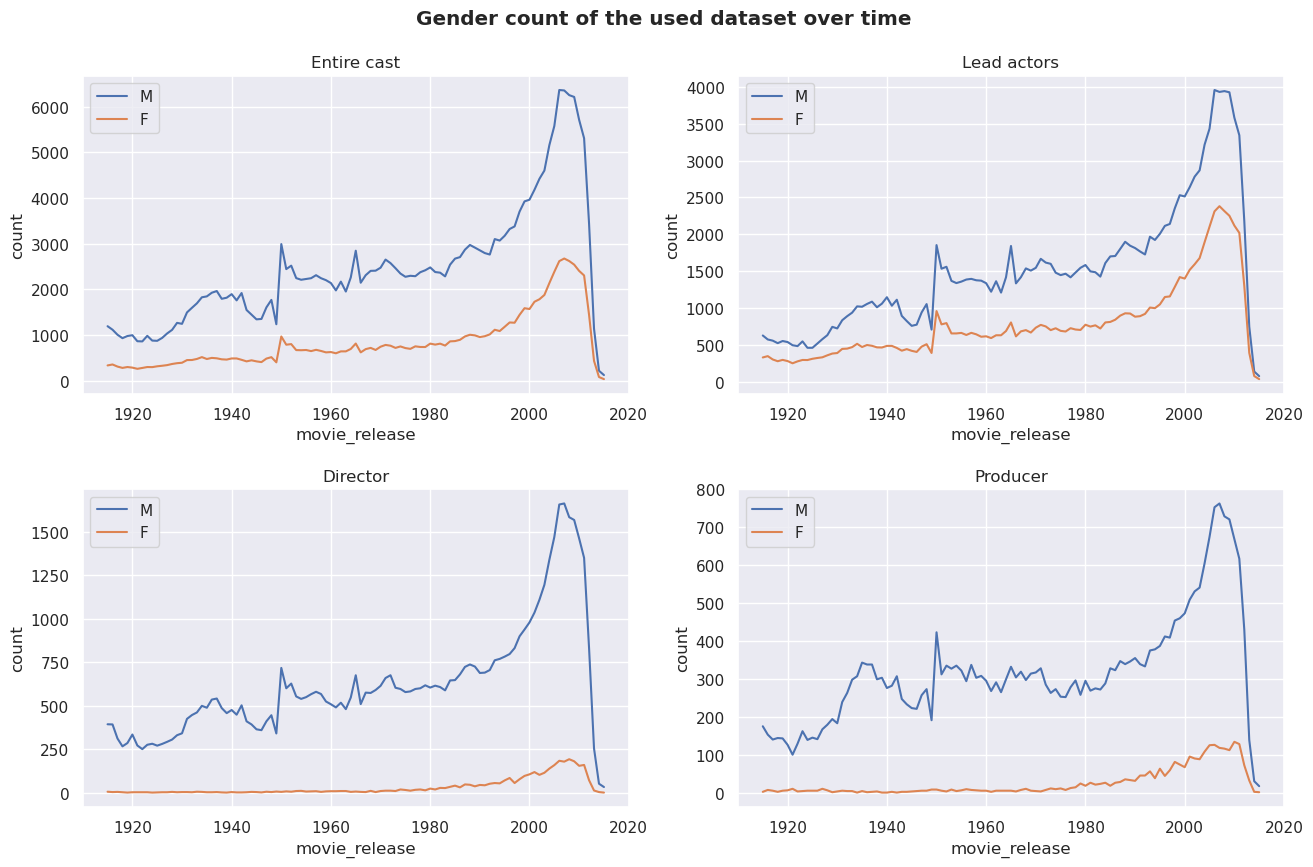

In [11]:
df_genders_count = df_genders.groupby('movie_release').sum()
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(15.5, 9.5, forward=True)
col_pairs = [
    ['male_all_count', 'female_all_count'], 
    ['male_actors_count', 'female_actors_count'], 
    ['male_director_count', 'female_director_count'], 
    ['male_producer_count', 'female_producer_count']
]
subplot_titles = [
    'Entire cast',
    'Lead actors',
    'Director',
    'Producer',
]

for i in range(2):
    for j in range(2):
        axs[i, j].set_title(subplot_titles[2*i+j])
        df = df_genders_count[col_pairs[2*i+j]].reset_index().melt('movie_release', var_name='category',  value_name='count')
        sns.lineplot(x='movie_release', y='count', hue='category', data=df, ax=axs[i,j])
        axs[i, j].legend("MF")
    
plt.subplots_adjust(hspace=0.3)
fig.suptitle("Gender count of the used dataset over time", y=0.95, fontweight="bold")
plt.show()

Here, we mainly observe our data distribution since we grouped by the year so the years with the most of movies will have the highest values. However, we can already see the discrepancy between the different categories where the director and producer have much less female compared to the lead actors.

To be able to better compare these results, we will compute the ration between male and female per category.

In [12]:
col_actors = ['cast_0_gender', 'cast_1_gender', 'cast_2_gender', 'cast_3_gender', 'cast_4_gender']
col_director = ['director_gender']
col_producer = ['producer_gender']

df_genders = df_genders[(df_genders['movie_release'] >= 1915) & (df_genders['movie_release'] <= 2015)]

# Compute ratio and normalize
df_genders['male_all'] = 100 * df_genders['male_all_count'] / (df_genders['male_all_count'] + df_genders['female_all_count'])
df_genders['male_actors'] = 100* df_genders['male_actors_count'] / (df_genders['male_actors_count'] + df_genders['female_actors_count'])
df_genders['male_director'] = 100*(df_genders['director_gender'] == 'male').astype(int) / ((df_genders['director_gender'] == 'male').astype(int) + (df_genders['director_gender'] == 'female').astype(int))
df_genders['male_producer'] = 100*(df_genders['producer_gender'] == 'male').astype(int) / ((df_genders['producer_gender'] == 'male').astype(int) + (df_genders['producer_gender'] == 'female').astype(int))

df_genders['female_all'] = 100 * df_genders['female_all_count'] / (df_genders['male_all_count'] + df_genders['female_all_count'])
df_genders['female_actors'] = 100 * df_genders['female_actors_count'] / (df_genders['female_actors_count'] + df_genders['male_actors_count'])
df_genders['female_director'] = 100*(df_genders['director_gender'] == 'female').astype(int) / ((df_genders['director_gender'] == 'male').astype(int) + (df_genders['director_gender'] == 'female').astype(int))
df_genders['female_producer'] = 100*(df_genders['producer_gender'] == 'female').astype(int) / ((df_genders['producer_gender'] == 'male').astype(int) + (df_genders['producer_gender'] == 'female').astype(int))

df_genders.head()

,movie_id,movie_release,movie_genre,director_gender,producer_gender,cast_0_gender,cast_1_gender,cast_2_gender,cast_3_gender,cast_4_gender,...,female_director_count,female_producer_count,male_all,male_actors,male_director,male_producer,female_all,female_actors,female_director,female_producer
30486,Q3987055,1915,silent film,male,NaN,female,male,NaN,NaN,NaN,...,0,0,66.666667,50.0,100.0,NaN,33.333333,50.0,0.0,NaN
34034,Q4659614,1915,drama film,male,NaN,male,female,male,male,male,...,0,0,83.333333,80.0,100.0,NaN,16.666667,20.0,0.0,NaN
30403,Q3985802,1915,war film,male,NaN,male,male,female,female,male,...,0,0,66.666667,60.0,100.0,NaN,33.333333,40.0,0.0,NaN
30517,Q3987128,1915,drama film,male,female,female,male,NaN,NaN,NaN,...,0,1,50.000000,50.0,100.0,0.0,50.000000,50.0,0.0,100.0
65909,Q7741008,1915,silent film,male,NaN,male,NaN,NaN,NaN,NaN,...,0,0,100.000000,100.0,100.0,NaN,0.000000,0.0,0.0,NaN


Then group them again by year

In [13]:
df_genders_per_year = df_genders.groupby('movie_release').agg({
    'male_all':['mean', 'std'],
    'male_actors':['mean', 'std'],
    'male_director':['mean', 'std'],
    'male_producer':['mean', 'std'],
    'female_all':['mean', 'std'],
    'female_actors':['mean', 'std'],
    'female_director':['mean', 'std'],
    'female_producer':['mean', 'std'],
})
df_genders_per_year.columns = [
    'male_all',
    'male_all_std',
    'male_actors',
    'male_actors_std',
    'male_director',
    'male_director_std',
    'male_producer',
    'male_producer_std',
    'female_all',
    'female_all_std',
    'female_actors',
    'female_actors_std',
    'female_director',
    'female_director_std',
    'female_producer',
    'female_producer_std',
]
df_genders_per_year = df_genders_per_year[df_genders_per_year.T.sum() > 0]
df_genders_per_year = df_genders_per_year.dropna()

std_cols = ['male_all_std', 'female_all_std', 'male_actors_std', 'female_actors_std', 'male_director_std', 'female_director_std', 'male_producer_std', 'female_producer_std']

df_stds = df_genders_per_year[std_cols]

df_genders_per_year = df_genders_per_year.drop(columns=std_cols)

df_genders_per_year.head()

,male_all,male_actors,male_director,male_producer,female_all,female_actors,female_director,female_producer
movie_release,,,,,,,,
1915,80.500957,67.053265,98.743719,98.870056,19.499043,32.946735,1.256281,1.129944
1916,78.965662,63.958904,99.240506,95.625000,21.034338,36.041096,0.759494,4.375000
1917,78.505001,61.270686,98.730159,96.551724,21.494999,38.729314,1.269841,3.448276
1918,79.500518,63.831259,99.253731,98.630137,20.499482,36.168741,0.746269,1.369863
1919,78.506344,62.601781,100.000000,96.621622,21.493656,37.398219,0.000000,3.378378


And finally plot them.

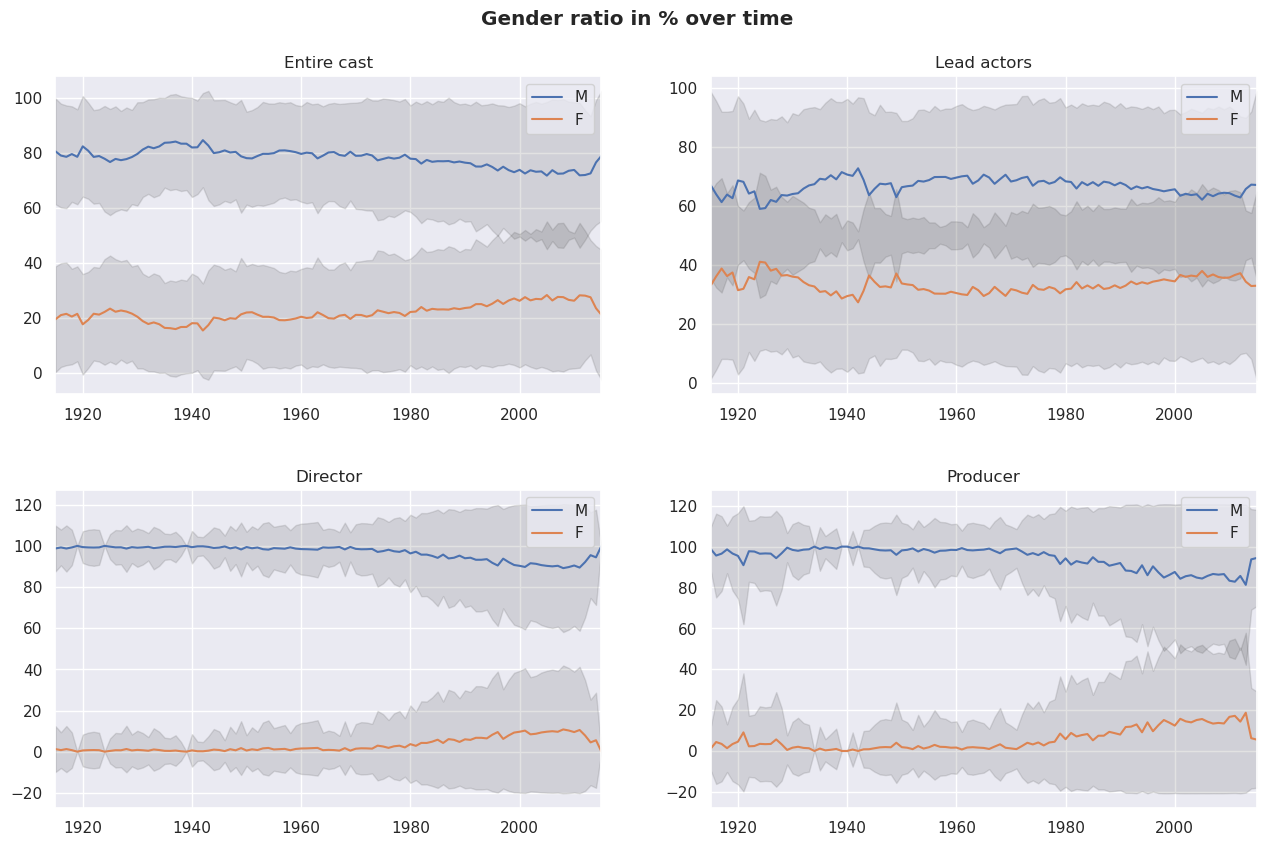

In [14]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(15.5, 9.5, forward=True)
col_pairs = [
    ['male_all', 'female_all'], 
    ['male_actors', 'female_actors'], 
    ['male_director', 'female_director'], 
    ['male_producer', 'female_producer']
]
subplot_titles = [
    'Entire cast',
    'Lead actors',
    'Director',
    'Producer',
]

for i in range(2):
    for j in range(2):
        axs[i, j].set_title(subplot_titles[2*i+j])
        df = df_genders_per_year[col_pairs[2*i+j]].copy()
        axs[i, j].plot(df)
        axs[i, j].legend("MF")
        df['lower_male'] = df[col_pairs[2*i+j][0]] - df_stds[col_pairs[2*i+j][0] + '_std']
        df['upper_male'] = df[col_pairs[2*i+j][0]] + df_stds[col_pairs[2*i+j][0] + '_std']
        axs[i,j].fill_between(df.index, df['lower_male'], df['upper_male'], color=(0.26, 0.26, 0.26, 0.15))

        df['lower_female'] = df[col_pairs[2*i+j][1]] - df_stds[col_pairs[2*i+j][1] + '_std']
        df['upper_female'] = df[col_pairs[2*i+j][1]] + df_stds[col_pairs[2*i+j][1] + '_std']
        axs[i,j].fill_between(df.index, df['lower_female'], df['upper_female'], color=(0.26, 0.26, 0.26, 0.15))
        axs[i, j].set_xlim([1915, 2015])
    
plt.subplots_adjust(hspace=0.3)
fig.suptitle("Gender ratio in % over time", y=0.95, fontweight="bold")
plt.show()

From these plots, we can see, that the male occupy around 2/3 of the lead actors while nearly all the main directors and producers roles are being held by males. Fortunately, we can see a trend of the gap closing slowly. Our data is representative until 2012 after which we can see a change in the closing gap which is due to the low amount of data.

Gender by genre

For now, we looked at the entire movie industry as one genre. However, with the many different genres that exist, it might be unfair to conclude anything without taking a deeper look into the different genres since one might think that in some genres, such as action and adventure, there may be a greater proportion of male leading roles, while in others, such as romantic comedy and drama, there may be a greater proportion of female leading roles.

In [15]:
genres = df_genders['movie_genre'].unique()
print(len(genres))
print(df_genders['movie_genre'].value_counts()[:15])

429
drama film              14706
comedy film              7349
documentary film         4295
horror film              3266
action film              3089
romantic comedy          2719
silent film              2099
musical film             1987
crime film               1907
romance film             1830
comedy drama             1631
Western film             1374
science fiction film     1304
biographical film        1172
fantasy film             1149
Name: movie_genre, dtype: int64


Since grouping by genre greatly reduces our dataset size for each genr, we group by every 5 years to have smoother visualizations.

In [16]:
df_genres_gender = df_genders.copy()
df_genres_gender = df_genres_gender[(df_genres_gender == 'male').T.sum() + (df_genres_gender == 'female').T.sum() > 0]

# Groupy by multiple years and use the start of interval as release year
df_genres_gender['movie_release'] = pd.to_datetime(df_genres_gender['movie_release'].astype(str), format='%Y')
df_genres_gender = df_genres_gender.groupby([pd.cut(df_genres_gender['movie_release'], pd.date_range('1915', '2020', freq='5Y')), 'movie_genre']).mean().reset_index()
df_genres_gender['movie_release'] = df_genres_gender['movie_release'].astype(str).str.extract(', (.+?)]').astype('datetime64[ns]').squeeze().dt.year

df_genres_gender = df_genres_gender[df_genres_gender['male_all'].notna()]
df_genres_gender.head()

,movie_release,movie_genre,male_all_count,male_actors_count,male_director_count,male_producer_count,female_all_count,female_actors_count,female_director_count,female_producer_count,male_all,male_actors,male_director,male_producer,female_all,female_actors,female_director,female_producer
13,1920,LGBT-related film,5.5,3.500000,1.000000,1.000000,1.500000,1.500000,0.000000,0.000000,78.571429,70.000000,100.000000,100.000000,21.428571,30.000000,0.000000,0.000000
24,1920,Western film,3.0,1.817518,0.970803,0.211679,0.481752,0.467153,0.007299,0.007299,89.916580,85.845588,99.253731,96.666667,10.083420,14.154412,0.746269,3.333333
29,1920,action film,4.2,2.600000,1.000000,0.600000,1.400000,1.400000,0.000000,0.000000,72.952381,60.666667,100.000000,100.000000,27.047619,39.333333,0.000000,0.000000
36,1920,adventure film,3.8,2.466667,1.000000,0.333333,1.133333,0.933333,0.000000,0.200000,77.095238,65.952381,100.000000,62.500000,22.904762,34.047619,0.000000,37.500000
57,1920,autobiography,1.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,100.000000,NaN,NaN,100.000000,0.000000,NaN,NaN,0.000000


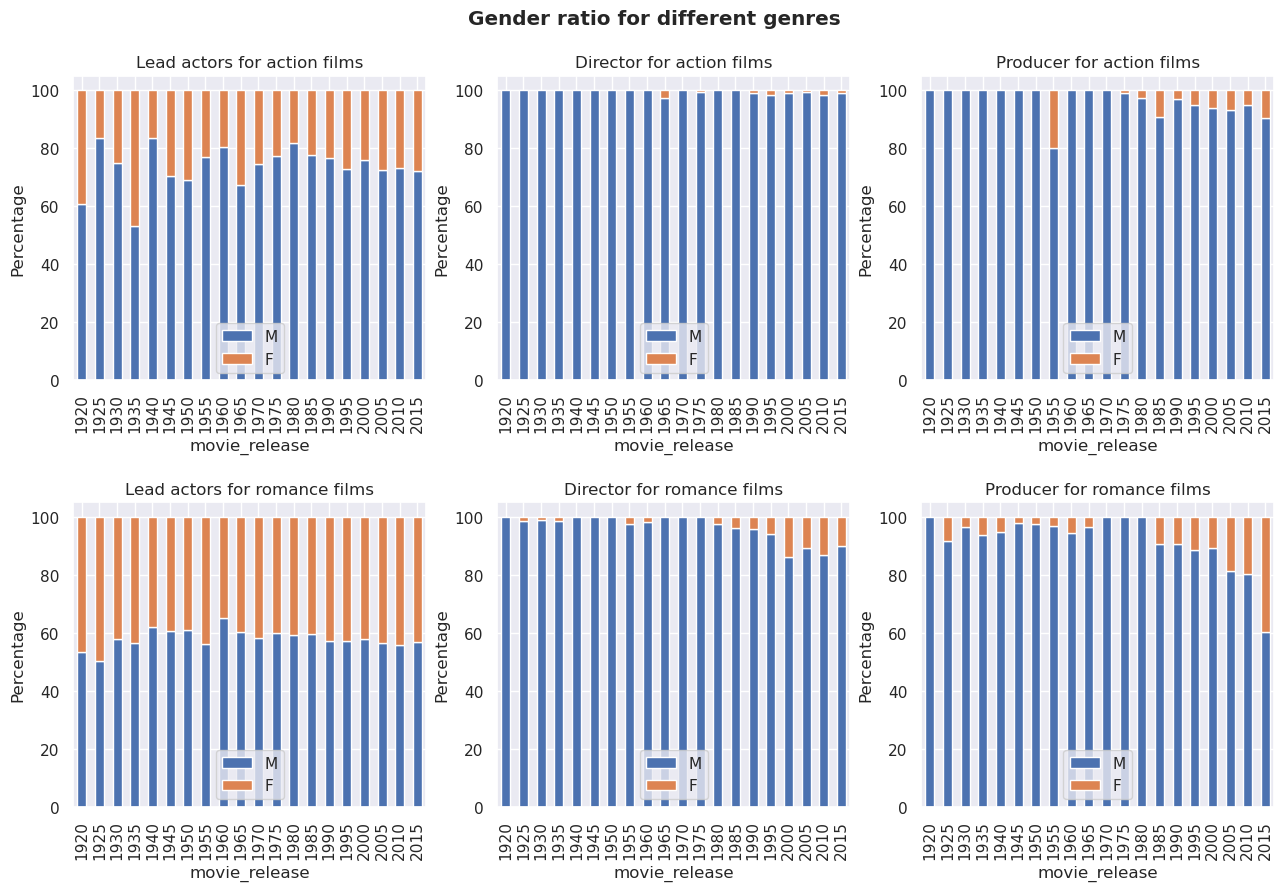

In [17]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(15.5, 9.5, forward=True)
col_pairs = [
    ['movie_release', 'male_actors', 'female_actors'],
    ['movie_release', 'male_director', 'female_director'], 
    ['movie_release', 'male_producer', 'female_producer'], 
    ['movie_release', 'male_actors', 'female_actors'], 
    ['movie_release', 'male_director', 'female_director'], 
    ['movie_release', 'male_producer', 'female_producer'], 
]
genres = [
    'action film',
    'action film',
    'action film',
    'romance film',
    'romance film',
    'romance film',
]
subplot_titles = [
    'Lead actors for action films',
    'Director for action films',
    'Producer for action films',
    'Lead actors for romance films',
    'Director for romance films',
    'Producer for romance films',
]

for i in range(2):
    for j in range(3):
        axs[i, j].set_title(subplot_titles[3*i+j])
        df = df_genres_gender[df_genres_gender['movie_genre']==genres[3*i+j]]
        df[col_pairs[3*i+j]].plot.bar(x='movie_release', stacked=True, ax=axs[i, j])
        axs[i, j].legend("MF")
        axs[i, j].set_ylabel('Percentage')
    
plt.subplots_adjust(hspace=0.4)
fig.suptitle("Gender ratio for different genres", y=0.95, fontweight="bold")
plt.show()

Here we now compare the leading actors with the directors and producers for two quite different genres: Action films and romantic films. We see that indeed the gender proportion changes in both genres. However, they are still mostly dominated by males. To get an overview of the top 10 genres and LGBT-related film, please refer to the [data story](https://imdbmi.github.io).

Gender wrt. revenue

After looking at the gender distribution we will take a look at the box office value to try to determine if the revenue changes if the leading roles are taken by a diverse team. Here, a diverse team will be a team that has a male and female proportion between 40% and 60% i.e. there are more than or equal 40% but less than or equal 60% of roles that are took by males.

We first load the box office value from the CMU movie dataset

In [18]:
cmu_data_folder = './data/raw/movie-summaries/'
meta = cmu_data_folder + 'movie.metadata.tsv'
meta_data = pd.read_csv(meta, sep='\t', 
                        names=['Wikipedia Movie ID', 'Freebase Movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres'])


In [19]:
meta_data = meta_data.sort_values('Movie box office revenue', ascending=False)
df_box_office = meta_data[['Freebase Movie ID', 'Movie box office revenue']].set_index('Freebase Movie ID')
df_box_office.head()

,Movie box office revenue
Freebase Movie ID,
/m/0bth54,2.782275e+09
/m/0dr_4,2.185372e+09
/m/062zm5h,1.511758e+09
/m/0gvsynb,1.328111e+09
/m/0872p_c,1.123747e+09


In [20]:
wikipedia_ids = pd.read_csv('./data/processed/wikipedia_ids.csv', index_col=0)
wikipedia_ids.head()

,Wikidata URI,Wikidata ID,IMDb ID
Freebase ID,,,
/m/03vyhn,http://www.wikidata.org/entity/Q261700,Q261700,tt0228333
/m/08yl5d,http://www.wikidata.org/entity/Q16250726,Q16250726,tt0245916
/m/0crgdbh,http://www.wikidata.org/entity/Q4978832,Q4978832,tt0094806
/m/0285_cd,http://www.wikidata.org/entity/Q7995657,Q7995657,tt0094320
/m/01mrr1,http://www.wikidata.org/entity/Q869644,Q869644,tt0083949


In [21]:
merged = pd.concat([df_box_office, wikipedia_ids], axis=1)
merged = merged[merged['Wikidata ID'].notna()]
df_box_office = merged[['Movie box office revenue', 'Wikidata ID']].set_index('Wikidata ID')
df_box_office.head()
merged.head()

,Movie box office revenue,Wikidata URI,Wikidata ID,IMDb ID
/m/0bth54,2.782275e+09,http://www.wikidata.org/entity/Q24871,Q24871,tt0499549
/m/0dr_4,2.185372e+09,http://www.wikidata.org/entity/Q44578,Q44578,tt0120338
/m/062zm5h,1.511758e+09,http://www.wikidata.org/entity/Q182218,Q182218,tt0848228
/m/0gvsynb,1.328111e+09,http://www.wikidata.org/entity/Q232009,Q232009,tt1201607
/m/0872p_c,1.123747e+09,http://www.wikidata.org/entity/Q232774,Q232774,tt1399103


And then merge it with the collected movie metadata from wikidata

In [22]:
df_box_genders = df_genders.copy()
df_box_genders = df_genders.set_index('movie_id')
df_box_genders = pd.concat([df_box_office, df_box_genders], axis=1)
df_box_genders = df_box_genders[df_box_genders['movie_release'].notna()]
df_box_genders['movie_release'] = df_box_genders['movie_release'].astype(int)
df_box_genders = df_box_genders.sort_values('movie_release')
df_box_genders.rename(columns={'Movie box office revenue':'box_office_value'}, inplace=True)
df_box_genders = df_box_genders[df_box_genders['box_office_value'].notna()]
df_box_genders.head()

,box_office_value,movie_release,movie_genre,director_gender,producer_gender,cast_0_gender,cast_1_gender,cast_2_gender,cast_3_gender,cast_4_gender,...,female_director_count,female_producer_count,male_all,male_actors,male_director,male_producer,female_all,female_actors,female_director,female_producer
Q220394,50000000.0,1915,drama film,male,male,female,female,female,male,male,...,0.0,0.0,57.142857,40.0,100.0,100.0,42.857143,60.0,0.0,0.0
Q7736329,100000.0,1918,science fiction film,male,male,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,100.000000,NaN,100.0,100.0,0.000000,NaN,0.0,0.0
Q1187189,4500000.0,1920,romance film,male,male,female,male,male,male,female,...,0.0,0.0,71.428571,60.0,100.0,100.0,28.571429,40.0,0.0,0.0
Q1219825,4500000.0,1921,romance film,male,NaN,male,female,male,male,female,...,0.0,0.0,66.666667,60.0,100.0,NaN,33.333333,40.0,0.0,NaN
Q374172,2500000.0,1921,comedy drama,male,male,female,male,male,male,female,...,0.0,0.0,71.428571,60.0,100.0,100.0,28.571429,40.0,0.0,0.0


Now, we need to adapt the box office value to inflation to be able to compare the different box office values over time

In [23]:
# load inflation data
inflation = pd.read_csv(CPI_PATH, names=['date', 'cpi'], skiprows=1)
inflation['date'] = pd.to_datetime(inflation['date'])
# calculate inflation multiplier
inflation['multiplier'] = inflation['cpi'].iloc[-1] / inflation['cpi']
multiplier_year = inflation.groupby(inflation['date'].dt.year).mean()
multiplier_year.head()

,cpi,multiplier
date,,
1913,9.883333,30.126541
1914,10.016667,29.726907
1915,10.108333,29.455613
1916,10.883333,27.389927
1917,12.825000,23.269261


In [24]:
df_box_genders = pd.merge(df_box_genders, multiplier_year, left_on='movie_release', right_on='date', how='left')
df_box_genders = df_box_genders[df_box_genders['cpi'].notna()]
df_box_genders['box_office_value'] = df_box_genders['box_office_value'] * df_box_genders['multiplier']
df_box_genders = df_box_genders.drop(columns=['cpi', 'multiplier'])
df_box_genders = df_box_genders.sort_values('box_office_value')
df_box_genders.head()

,box_office_value,movie_release,movie_genre,director_gender,producer_gender,cast_0_gender,cast_1_gender,cast_2_gender,cast_3_gender,cast_4_gender,...,female_director_count,female_producer_count,male_all,male_actors,male_director,male_producer,female_all,female_actors,female_director,female_producer
7199,13877.819654,2009,documentary film,female,male,male,female,male,female,female,...,1.0,0.0,42.857143,40.0,0.0,100.0,57.142857,60.0,100.0,0.0
7830,13926.205238,2010,documentary film,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7833,14567.902930,2010,drama film,male,female,female,male,female,female,male,...,0.0,1.0,42.857143,40.0,100.0,0.0,57.142857,60.0,0.0,100.0
7834,15343.401418,2010,comedy drama,male,male,male,female,male,male,female,...,0.0,0.0,71.428571,60.0,100.0,100.0,28.571429,40.0,0.0,0.0
7068,15621.954712,2008,pornographic film,male,NaN,male,male,female,male,NaN,...,0.0,0.0,80.000000,75.0,100.0,NaN,20.000000,25.0,0.0,NaN


Divide the box office values into 50 bins to get a smoother plot

In [25]:
df_box_per_years = df_box_genders.reset_index(drop=True)
bins = 50
divider = len(df_box_per_years) / bins
df_box_per_years = df_box_per_years.groupby(df_box_per_years.index // divider).agg({
    'box_office_value':'mean',
    'male_all':['mean', 'std'],
    'male_actors':['mean', 'std'],
    'male_director':['mean', 'std'],
    'male_producer':['mean', 'std'],
    'female_all':['mean', 'std'],
    'female_actors':['mean', 'std'],
    'female_director':['mean', 'std'],
    'female_producer':['mean', 'std'],
})

df_box_per_years.columns = [
    'box_office_value',
    'male_all',
    'male_all_std',
    'male_actors',
    'male_actors_std',
    'male_director',
    'male_director_std',
    'male_producer',
    'male_producer_std',
    'female_all',
    'female_all_std',
    'female_actors',
    'female_actors_std',
    'female_director',
    'female_director_std',
    'female_producer',
    'female_producer_std',
]

df_box_per_years = df_box_per_years.set_index('box_office_value')

std_cols = ['male_all_std', 'female_all_std', 'male_actors_std', 'female_actors_std', 'male_director_std', 'female_director_std', 'male_producer_std', 'female_producer_std']

df_stds = df_box_per_years[std_cols]

df_box_per_years = df_box_per_years.drop(columns=std_cols)

df_box_per_years.head()

,male_all,male_actors,male_director,male_producer,female_all,female_actors,female_director,female_producer
box_office_value,,,,,,,,
43135.920860,69.788690,63.139269,89.361702,79.545455,30.211310,36.860731,10.638298,20.454545
134472.989735,69.323232,60.608108,87.012987,85.046729,30.676768,39.391892,12.987013,14.953271
294238.410207,73.988812,65.217865,91.772152,90.526316,26.011188,34.782135,8.227848,9.473684
532461.222460,70.953833,64.692144,88.461538,81.308411,29.046167,35.307856,11.538462,18.691589
868852.788473,70.839827,62.225738,91.719745,86.538462,29.160173,37.774262,8.280255,13.461538


Finally, we can now plot the gender ratio regarding the box office value over the years for each category to get a first overview

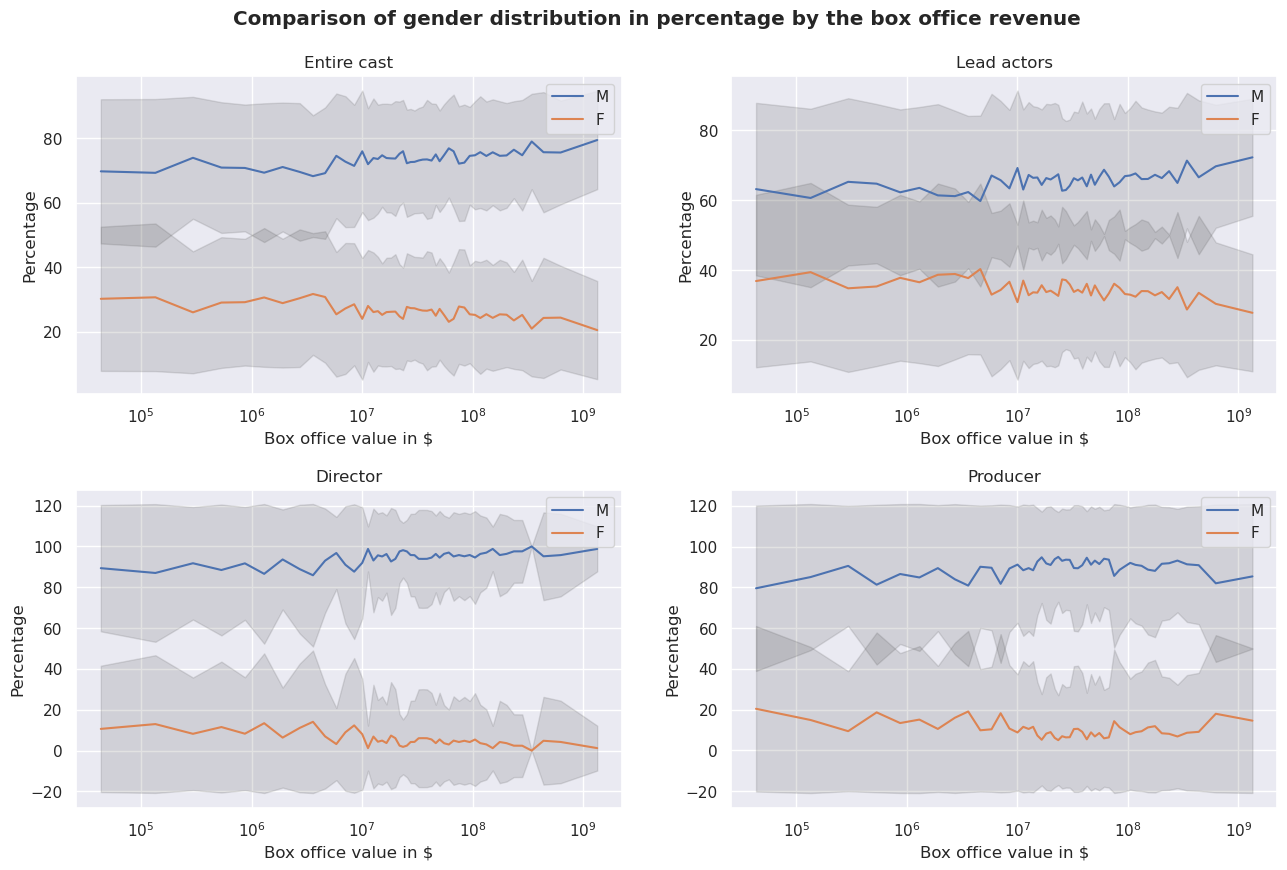

In [26]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(15.5, 9.5, forward=True)
col_pairs = [
    ['male_all', 'female_all'], 
    ['male_actors', 'female_actors'], 
    ['male_director', 'female_director'], 
    ['male_producer', 'female_producer']
]
subplot_titles = [
    'Entire cast',
    'Lead actors',
    'Director',
    'Producer',
]

for i in range(2):
    for j in range(2):
        axs[i, j].set_title(subplot_titles[2*i+j])
        df = df_box_per_years[col_pairs[2*i+j]].copy()
        axs[i, j].plot(df)
        axs[i, j].legend("MF")
        df['lower_male'] = df[col_pairs[2*i+j][0]] - df_stds[col_pairs[2*i+j][0] + '_std']
        df['upper_male'] = df[col_pairs[2*i+j][0]] + df_stds[col_pairs[2*i+j][0] + '_std']
        axs[i,j].fill_between(df.index, df['lower_male'], df['upper_male'], color=(0.26, 0.26, 0.26, 0.15))

        df['lower_female'] = df[col_pairs[2*i+j][1]] - df_stds[col_pairs[2*i+j][1] + '_std']
        df['upper_female'] = df[col_pairs[2*i+j][1]] + df_stds[col_pairs[2*i+j][1] + '_std']
        axs[i,j].fill_between(df.index, df['lower_female'], df['upper_female'], color=(0.26, 0.26, 0.26, 0.15))
        axs[i, j].set_xscale('log')
        axs[i, j].set_xlabel('Box office value in $')
        axs[i, j].set_ylabel('Percentage')
    
plt.subplots_adjust(hspace=0.3)
fig.suptitle("Comparison of gender distribution in percentage by the box office revenue", y=0.95, fontweight="bold")
plt.show()

Here we actually seem to see the opposite as above. Instead of the gender gap closing, it now gets bigger with increasing box office value. One might make the assumption, that movies dominated by male in leading positions might actually by more successful wrt. to the box office value than movies with diverse leading roles.

To evaluate this assumption, we will use Linear regression and try to fit the box office value using the ratio of males.

In [27]:
mod = smf.ols(formula='box_office_value ~ C(male_all)', data=df_box_genders)
np.random.seed(2)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       box_office_value   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     9.165
Date:                Fri, 23 Dec 2022   Prob (F-statistic):           1.71e-25
Time:                        22:17:01   Log-Likelihood:            -1.7224e+05
No. Observations:                8294   AIC:                         3.445e+05
Df Residuals:                    8275   BIC:                         3.447e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

We observe a small R-squared indicating that the relationship between the gender ratio and the box office value might actually not be that important.

Another way to evaluate the relationship between the gender ratio and box office value is to compute the correlation between these 2 variables.

In [28]:
df_corr = df_box_genders[df_box_genders['male_all'].notna()]
print('Pearson correlation between the gender ratio and the box office value : {}'.format(stats.pearsonr(df_corr['male_all'], df_corr['box_office_value'])))
print('Spearman correlation between the gender ratio and the box office value : {}'.format(stats.spearmanr(df_corr['male_all'], df_corr['box_office_value'])))

Pearson correlation between the gender ratio and the box office value : (0.06304175985911405, 9.129729978523765e-09)
Spearman correlation between the gender ratio and the box office value : SpearmanrResult(correlation=0.10917617906248597, pvalue=2.0386323073128265e-23)


In both cases with the Pearson and Spearman correlation, we observe pretty low correlation validating our results from before.

We will now split our data into 2 populations:
- **Diverse**: Ratio >= 40% and ratio <= 60%
- **Not diverse**: Ratio < 40% or ratio > 60%

In [29]:
df_diversity = df_box_genders[['box_office_value', 'male_all']].copy()
df_diversity['diverse_all'] = ((df_diversity['male_all'] >= 40) & (df_diversity['male_all'] <= 60)).astype(int)
df_diversity.drop(columns='male_all', inplace=True)

In [30]:
df_diversity[df_diversity['diverse_all']==1].describe()

,box_office_value,diverse_all
count,1.750000e+03,1750.0
mean,9.375896e+07,1.0
std,2.887861e+08,0.0
min,1.387782e+04,1.0
25%,5.427600e+06,1.0
50%,2.432015e+07,1.0
75%,8.164924e+07,1.0
max,8.562565e+09,1.0


In [31]:
df_diversity[df_diversity['diverse_all']==0].describe()

,box_office_value,diverse_all
count,6.562000e+03,6562.0
mean,1.045484e+08,0.0
std,2.452457e+08,0.0
min,1.392621e+04,0.0
25%,9.572184e+06,0.0
50%,3.001835e+07,0.0
75%,9.801717e+07,0.0
max,7.418224e+09,0.0


In [32]:
mean_difference = df_diversity[df_diversity['diverse_all']==0]['box_office_value'].mean() - df_diversity[df_diversity['diverse_all']==1]['box_office_value'].mean()
print(f'The mean difference between the box office revenue of a not diverse cast and a diverse cast for our dataset is: {mean_difference:.0f}')

The mean difference between the box office revenue of a not diverse cast and a diverse cast for our dataset is: 10789451


We observe a mean difference between these 2 populations of 10 789 451$. We thus can create the following null and alternative hypothesis:
- $H_0: p \leq .05$ Whethever a cast is diverse or not **has no** effect on the box office value
- $H_a: p \gt .05$ A not diverse cast **has** a higher box office value

In [33]:
independent = ttest_ind(df_diversity[df_diversity['diverse_all']==0]['box_office_value'], df_diversity[df_diversity['diverse_all']==1]['box_office_value'])
print(f'Independent sample t-test between a Diverse and a not diverse cast regarding the box office revenue, statistics: {independent[0]:.4f}, p-value: {independent[1]:.4f}')

Independent sample t-test between a Diverse and a not diverse cast regarding the box office revenue, statistics: 1.5725, p-value: 0.1159


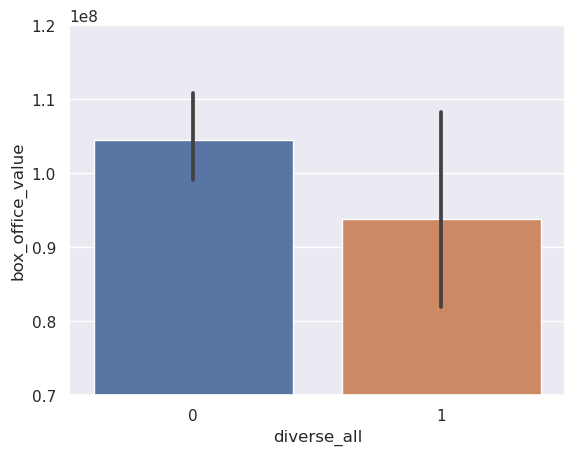

In [34]:
ax = sns.barplot(x="diverse_all", y="box_office_value", data=df_diversity[['box_office_value','diverse_all']])
plt.ylim([7e7,12e7]);

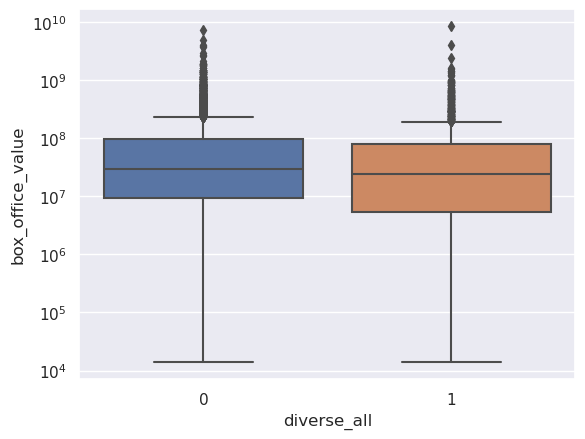

In [35]:
ax = sns.boxplot(x="diverse_all", y="box_office_value", data=df_diversity[['box_office_value','diverse_all']])
ax.set_yscale('log')

We obtain a p-value of 0.1159 so we **fail** to reject the null hypothesis. It is thus not possible to determine if a movie will have a higher or lower box office value only based on the gender diversity of the leading cast. This can also be observed in the two plots above. While the average might differ by quite a lot, but the 95% confidence intervals overlaps indicating that the difference is not that significant.